# Test the runtime of IBD calling

In [111]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from itertools import combinations

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ibd_euro/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

#sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/") 
#from main import HMM_Full
#from ancIBD.run import hapBLOCK_chrom, run_plot_pair
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/")  # hack to get development package first in path
from ancIBD.run import hapBLOCK_chroms, hapBLOCK_times

### hapsburgImport
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")
#from hapsburg.PackagesSupport.parallel_runs.helper_functions import combine_individual_data

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

compute-e-16-229.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/ibd_euro


# Do a single run for one pair

In [2]:
### From the all.v1 run
version = "53.1"
folder_in =  f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v{version}/ch" # for hdf5
path_meta =  f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v{version}.tsv" # for iids

df = pd.read_csv(path_meta, sep="\t")
print(f'Loaded Meta File with {len(df)} Samples')
min_cov = np.min(df["n_cov_snp"])
print(f"Minimum #1240k SNPs: {min_cov}")

Loaded Meta File with 8818 Samples
Minimum #1240k SNPs: 600109


# 0) Define Timing functions for various tests (linear loading, batch loading)

In [3]:
def time_2samples_wg(iid2, chs=range(1,23)):
    """Times two samples for their whole genome.
    Return: Runtime, IBD df"""
    start = time() # Start Clock
    df_ibds = []
    dft = pd.DataFrame(columns=["iid1","iid2", 'ch', "t_load", "t_pp", "t_run"])
    
    for ch in chs:
        df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids2, run_iids=[iids2],
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        dft.loc[len(dft)] = [iid2[0],iid2[1],ch, t2-t1, t3-t2, t4-t3]
        df_ibds.append(df_ibd)
    df_ibd = pd.concat(df_ibds)
    runtime = time() - start # Runtime in s
    
    return runtime, df_ibd, dft


def run_time_random_batch(n=100):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    

    pairs = [np.random.choice(df["iid"], 2) for _ in range(n)]
    iids = list(set(np.concatenate(pairs)))
    dft = pd.DataFrame(columns=["n", 'ch', "t_load", "t_pp", "t_run", "t_full"])
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        
        start = time()
        df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        runtime2 = time() - start
        dft.loc[len(dft)] = [n, ch, t2-t1, t3-t2, t4-t3, runtime2]
    return dft


def run_time_allpairs(n=10):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    

    iids =  np.random.choice(df["iid"], n)
    pairs = list(combinations(iids, 2))
    print(f"Running {len(pairs)} Pairs of samples when loading {n} IIDs")
    dft = pd.DataFrame(columns=["n", 'ch', "t_load", "t_pp", "t_run", "t_full"])
    
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        start = time()
        df_ibd2 = df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        runtime = time() - start
        dft.loc[len(dft)] = [n, ch, t2-t1, t3-t2, t4-t3, runtime]
    
    return dft

In [32]:
#iids2 = df["iid"][:2]
iids2 = ["I22118", "I22122"]
runtime, df_ibd, dft = time_2samples_wg(iids2)

## A) Do large scale testing of pairs

In [ ]:
n = 100

runtimes, sumibd, load_times, pp_times, ibd_times = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
iid1, iid2 = np.zeros(n, dtype="object"), np.zeros(n, dtype="object")

for i in range(n):
    print(f"Doing run: {i}")
    iids2 = np.random.choice(df["iid"], 2)
    iid1[i], iid2[i] = iids2
    runtime, df_ibd, dft = time_2samples_wg(iids2)
    runtimes[i] = runtime
    load_times[i] = np.sum(dft["t_load"])
    pp_times[i] = np.sum(dft["t_pp"])
    ibd_times[i] = np.sum(dft["t_run"])
    
    sumibd[i] = np.sum(df_ibd["lengthM"])
    
dft = pd.DataFrame({"iid1":iid1, "iid2":iid2, "sumIBD":sumibd, "runtime":runtimes, 
                    "t_load":load_times, "t_pp": pp_times, "t_run":ibd_times})

In [ ]:
dft

In [38]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100b.tsv"
dft.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft)} runtimes to: {savepath}")

Saved 100 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100b.tsv


## B) Do large scale testing of linear loading of pairs

In [ ]:
dft = run_time_random_batch(n=2)

In [ ]:
dft

### Run the full test for various batch sizes

In [ ]:
ns = [2, 5, 10, 20, 50, 100]
dfts  = [run_time_random_batch(n=n) for n in ns]
dft2 = pd.concat(dfts)
#dft2 = pd.DataFrame({"#Pairs":ns, "runtime":runtimes})

In [ ]:
dft2#.groupby("n")

In [64]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100b.tsv"
dft2.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft2)} runtimes to: {savepath}")

Saved 132 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100b.tsv


## C) Run pairs of samples when loading batch of individuals

In [ ]:
dft = run_time_allpairs(4)

## Do the array run

In [ ]:
ns = np.arange(2,17,2)
dfts  = [run_time_allpairs(n=n) for n in ns]
dft3 = pd.concat(dfts)
#dft3 = pd.DataFrame({"#samples":ns, "#pairs":ns*(ns-1)/2, "runtime":runtimes})

In [15]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches16b.tsv"
dft3.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft3)} runtimes to: {savepath}")

Saved 176 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches16b.tsv


### Do even bigger sets

In [116]:
ns = np.arange(2,51,8)
#ns = np.arange(2,17,2)
ns

array([ 2, 10, 18, 26, 34, 42, 50])

In [ ]:
ns = np.arange(2,51,8)
dfts  = [run_time_allpairs(n=n) for n in ns]
dft3 = pd.concat(dfts)

savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches50b.tsv"
dft3.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft3)} runtimes to: {savepath}")

# 2)a) Plot the runtime with the updated results

In [ ]:
df1 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100.tsv", sep="\t")
df2 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv", sep="\t")
df3 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv", sep="\t")

# 2) Plot the runtime

In [103]:
df2 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv", sep="\t")
df3 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv", sep="\t")

In [104]:
df2

,#Pairs,runtime
0,2,51.216418
1,5,113.760981
2,10,223.853577
3,20,407.942779
4,50,929.377592
5,100,1827.810927


In [105]:
def plot_runtimes_curve(ax=False, show=False,
                        fs=12, lw = .5, s = 50, savepath=""):
    """Plot the scaling of runtimes"""

    if not ax:
        plt.figure(figsize=(5,5))
        ax = plt.gca()

    #ax.plot([0,df2["#Pairs"].values[-1]],[0, df2["runtime"].values[-1]], c="gray", linestyle='dashed')
    ax.plot(df2["#Pairs"].values, df2["runtime"].values, c="#f72585")
    ax.scatter(df2["#Pairs"], df2["runtime"], ec="k", s=s, c="#f72585", label="Separate Loading", lw=lw)

    ax.plot(df3["#pairs"].values, df3["runtime"].values, c="#4361ee")
    ax.scatter(df3["#pairs"], df3["runtime"], ec="k", s=s, c="#4361ee", label="Batch Loading", lw=lw)

    leg = ax.legend(loc="upper left", fontsize=fs)
    ax.set_xlabel("Sample Pairs [# Pairs]", fontsize=fs)
    ax.set_ylabel("Runtime [s]", fontsize=fs)
    
    ax.tick_params(axis='both', which='major', labelsize=fs*0.8)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
        print(f"Saved to {savepath}")
    if show:
        plt.show()
        
def plot_runtime_bars(ax=False, show=False, fs=14, 
                      figsize=(8,8), width=0.8, 
                      ec = "gray", cs = ["#0a9396", "#ee9b00" ,"#ae2012"]):
    """Plot runtime bars (normalized per sample pair)"""

    ns = df_rt.index.values.astype("int8")
    x = np.arange(len(ns))

    if not ax:
        plt.figure(figsize=figsize)
        ax = plt.gca()

    #ax.plot(ns, dft["t_full"], "o")

    ax.bar(x, df_rt["t_load"], width, label='Loading', ec=ec, color=cs[0])
    ax.bar(x, df_rt["t_pp"], width, bottom=df_rt["t_load"],
           label='Pre-Procssing', ec=ec, color=cs[1])
    ax.bar(x, df_rt["t_run"], width, bottom=df_rt["t_load"]+df_rt["t_pp"],
           label='IBD Screening', ec=ec, color=cs[2])

    leg = ax.legend(loc="upper right", fontsize=fs, title="Runtime")
    leg.get_title().set_fontsize(fs)


    ax.set_xticks(x)
    ax.set_xticklabels(ns)
    ax.set_xlabel("Batch Size [# Inds]", fontsize=fs)
    ax.set_ylabel("Runtime per IBD pair [s]", fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs*0.8)
    
    ax.plot()
    if show:
        plt.show()

Saved to /n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf


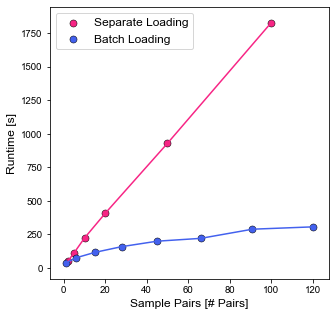

In [106]:
plot_runtimes_curve(show=True, savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf")

# 2) Make Benchmarks with load time and run time

In [122]:
50*49/2

1225.0

In [118]:
dft = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches50b.tsv", sep="\t")
dft = dft.groupby("n").sum()
ns = dft.index.values
pairs = ns * (ns - 1) / 2
df_rt = dft[["t_load", "t_pp", "t_run", "t_full"]]/pairs[:,None]
df_rt["pairs"] = pairs

In [119]:
df_rt

,t_load,t_pp,t_run,t_full,pairs
n,,,,,
2.0,31.500341,1.032163,0.423012,32.956646,1.0
10.0,2.744530,0.019219,0.349829,3.113623,45.0
18.0,1.327230,0.005336,0.347183,1.679778,153.0
26.0,0.921343,0.002522,0.347117,1.271008,325.0
34.0,0.748908,0.001462,0.349366,1.099761,561.0
42.0,0.559504,0.000965,0.350433,0.910928,861.0
50.0,0.422368,0.000645,0.352898,0.775936,1225.0


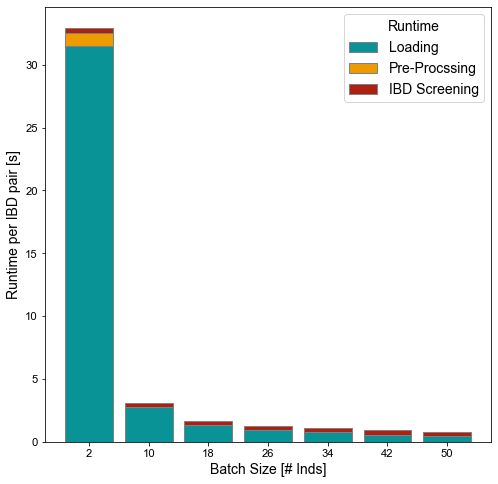

In [120]:
plot_runtime_bars(show=True)

Saved to /n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/panel.v1.pdf


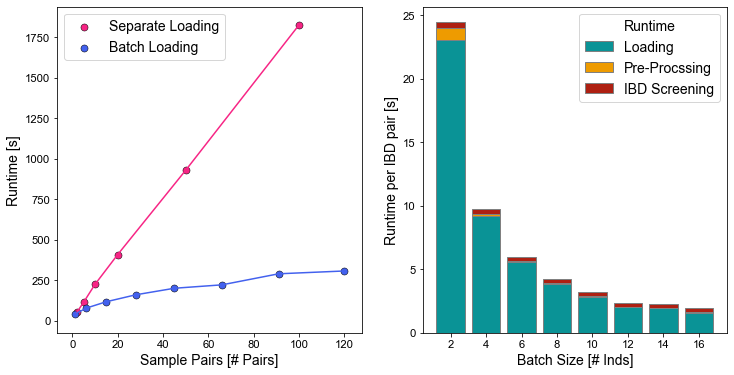

In [112]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/panel.v1.pdf"
fs = 14

fig =plt.figure(figsize=(12,6))
gs = fig.add_gridspec(nrows=1, ncols=2, wspace=0.2)

ax = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

plot_runtimes_curve(ax=ax, fs=fs)
plot_runtime_bars(ax=ax1, fs=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
                  
plt.show()

# Find out Platform CPU

In [82]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        print("Dindows")
        return platform.processor()
    elif platform.system() == "Linux":
        print("Linux")
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

In [83]:
get_processor_name()

Linux


' Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz'

# Area 51

In [10]:
from time import time

In [18]:
start = time()
a = np.arange(100000000)
a = np.square(a)
end = time()
end - start

1.2364563941955566